#### Imports

In [ ]:
from environments import build_blue_agent, build_red_agent, sample

import ray
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
logger = logging.getLogger(__name__)


#### Verify GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Train Dedicated Agents

In [3]:
# Start Ray
ray.init(ignore_reinit_error=True, log_to_driver=False)

red = build_red_agent(dedicated=True)

red_scores = [[],[],[],[],[]]

print("+--------------------+")
print("| Red Training Start |")
print("+--------------------+")

for g in range(1,5):
    path_file = open(f"./policies/red_dedicated_pool/dedicated_red_0/checkpoint_path", "r")
    red_restore_path = path_file.read()
    path_file.close()
    red.restore(red_restore_path)
    
    print()
    print("+--------------------+")
    print(f"| Red Policy {g} Start |")
    print("+--------------------+")
    print()

    red_max = 0

    for b in range(1, 101):
        result = red.train()
        red_score = result["sampler_results"]["episode_reward_mean"]
        print(f'Red Score for Batch {b}: {red_score:0.2f}')
        red_scores[g].append(red_score)
        if red_score > red_max:
            red_max = red_score
            checkpoint_path = red.save(checkpoint_dir=f"./policies/red_dedicated_pool/dedicated_red_{g}")
            path_file = open(f"./policies/red_dedicated_pool/dedicated_red_{g}/checkpoint_path", "w")
            path_file.write(checkpoint_path)
            path_file.close()
    print(checkpoint_path)

./policies/red_dedicated_pool/dedicated_red_0/checkpoint_000000
+--------------------+
| Red Training Start |
+--------------------+

+--------------------+
| Red Policy 1 Start |
+--------------------+

Red Score for Batch 1: 0.03
Red Score for Batch 2: 0.04
Red Score for Batch 3: 0.08
Red Score for Batch 4: 0.15
Red Score for Batch 5: 0.28
Red Score for Batch 6: 0.49
Red Score for Batch 7: 0.75
Red Score for Batch 8: 1.08
Red Score for Batch 9: 1.43
Red Score for Batch 10: 1.76
Red Score for Batch 11: 2.04
Red Score for Batch 12: 2.23
Red Score for Batch 13: 2.38
Red Score for Batch 14: 2.52
Red Score for Batch 15: 2.66
Red Score for Batch 16: 2.81
Red Score for Batch 17: 2.95
Red Score for Batch 18: 3.13
Red Score for Batch 19: 3.34
Red Score for Batch 20: 3.52
Red Score for Batch 21: 3.70
Red Score for Batch 22: 3.85
Red Score for Batch 23: 3.98
Red Score for Batch 24: 4.11
Red Score for Batch 25: 4.26
Red Score for Batch 26: 4.37
Red Score for Batch 27: 4.51
Red Score for Batch 28

In [5]:
# find dedicated agent that achieved the best score
r_max = 0
r_id = 0
for g in range(1,5):
    if max(red_scores[g]) > r_max:
        r_max = max(red_scores[g])
        r_id = g
print()
print(f'Dedicated Red Agent {r_id} reached the highest score.')

path_file = open(f"./policies/red_dedicated_pool/dedicated_red_{r_id}/checkpoint_path", "r")
dedicated_red_path = path_file.read()
path_file.close()
path_file = open(f"./policies/dedicated_red_policy", "w")
path_file.write(dedicated_red_path)
path_file.close()

ray.shutdown()


Dedicated Red Agent 3 reached the highest score.


In [8]:
# Start Ray
ray.init(ignore_reinit_error=True, log_to_driver=False)

blue = build_blue_agent(dedicated=True)

blue_scores = [[],[],[],[],[]]

print()
print("+---------------------+")
print("| Blue Training Start |")
print("+---------------------+")
print()

for g in range(1,5):
    path_file = open(f"./policies/blue_dedicated_pool/dedicated_blue_0/checkpoint_path", "r")
    blue_restore_path = path_file.read()
    path_file.close()
    blue.restore(blue_restore_path)

    print()
    print("+---------------------+")
    print(f"| Blue Policy {g} Start |")
    print("+---------------------+")
    print()

    for b in range(1, 101):
        result = blue.train()
        blue_score = -result["sampler_results"]["episode_reward_mean"]
        print(f'Blue Score for Batch {b}: {blue_score:0.2f}')
        blue_scores[g].append(blue_score)
    checkpoint_path = blue.save(checkpoint_dir=f"./policies/blue_dedicated_pool/dedicated_blue_{g}")
    path_file = open(f"./policies/blue_dedicated_pool/dedicated_blue_{g}/checkpoint_path", "w")
    path_file.write(checkpoint_path)
    path_file.close()

./policies/blue_dedicated_pool/dedicated_blue_0/checkpoint_000000

+---------------------+
| Blue Training Start |
+---------------------+


+---------------------+
| Blue Policy 1 Start |
+---------------------+

Blue Score for Batch 1: 12.79
Blue Score for Batch 2: 11.65
Blue Score for Batch 3: 10.41
Blue Score for Batch 4: 9.44
Blue Score for Batch 5: 8.65
Blue Score for Batch 6: 8.24
Blue Score for Batch 7: 7.66
Blue Score for Batch 8: 7.00
Blue Score for Batch 9: 6.46
Blue Score for Batch 10: 5.92
Blue Score for Batch 11: 5.53
Blue Score for Batch 12: 5.21
Blue Score for Batch 13: 5.00
Blue Score for Batch 14: 4.83
Blue Score for Batch 15: 4.69
Blue Score for Batch 16: 4.63
Blue Score for Batch 17: 4.55
Blue Score for Batch 18: 4.49
Blue Score for Batch 19: 4.45
Blue Score for Batch 20: 4.41
Blue Score for Batch 21: 4.41
Blue Score for Batch 22: 4.38
Blue Score for Batch 23: 4.38
Blue Score for Batch 24: 4.37
Blue Score for Batch 25: 4.37
Blue Score for Batch 26: 4.36
Blue Score f

In [9]:
# find dedicated agents that achieved the best scores
b_min = float('inf')
b_id = 0

for g in range(1,5):
    if min(blue_scores[g]) < b_min:
        b_min = min(blue_scores[g])
        b_id = g

print()
print(f'Dedicated Blue Agent {b_id} reached the lowest score.')

path_file = open(f"./policies/blue_dedicated_pool/dedicated_blue_{b_id}/checkpoint_path", "r")
dedicated_blue_path = path_file.read()
path_file.close()
path_file = open(f"./policies/dedicated_blue_policy", "w")
path_file.write(dedicated_blue_path)
path_file.close()

ray.shutdown()


Dedicated Blue Agent 4 reached the lowest score.


#### Training Graphs

Dedicated Red Agent 1


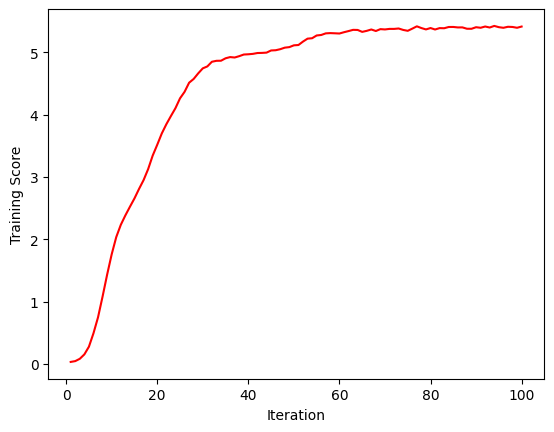

Dedicated Red Agent 2


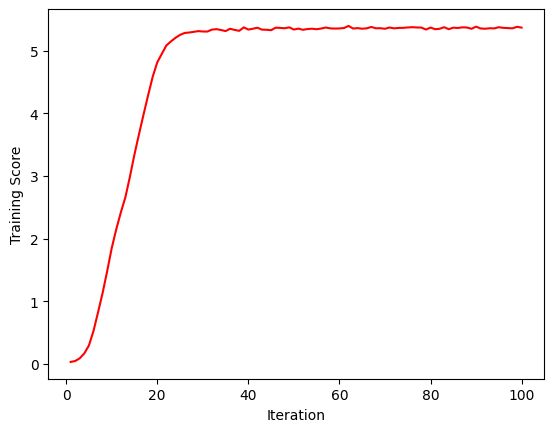

Dedicated Red Agent 3


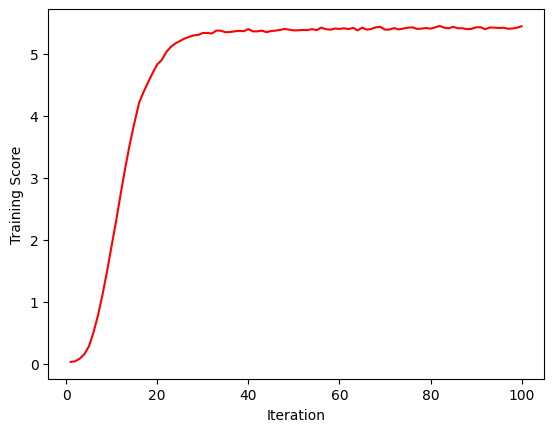

Dedicated Red Agent 4


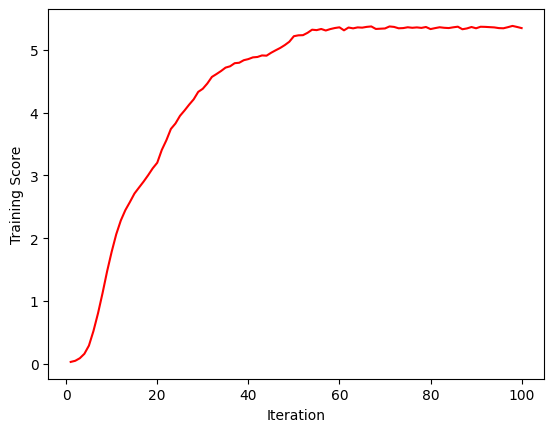

In [10]:
# Scores During Training
id_plot = [id for id in range(1,101)]
for g in range(1,5):
    print(f'Dedicated Red Agent {g}')
    data_plot = pd.DataFrame({"Iteration":id_plot, "Training Score":red_scores[g]})
    plt.figure()
    sns.lineplot(x = "Iteration", y = "Training Score", data=data_plot, color='red')
    plt.show()

Dedicated Blue Agent 1


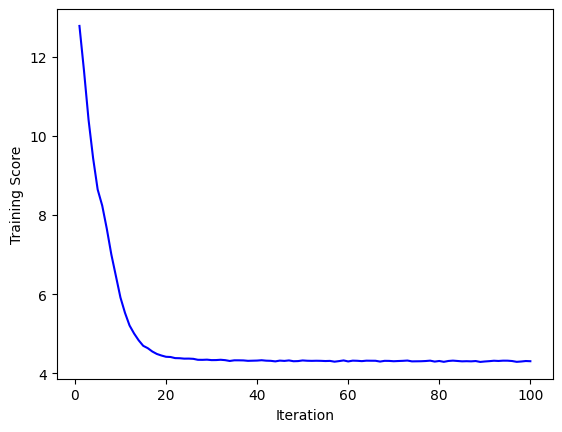

Dedicated Blue Agent 2


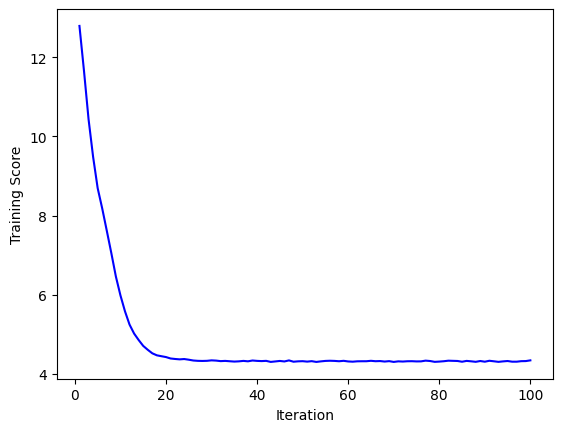

Dedicated Blue Agent 3


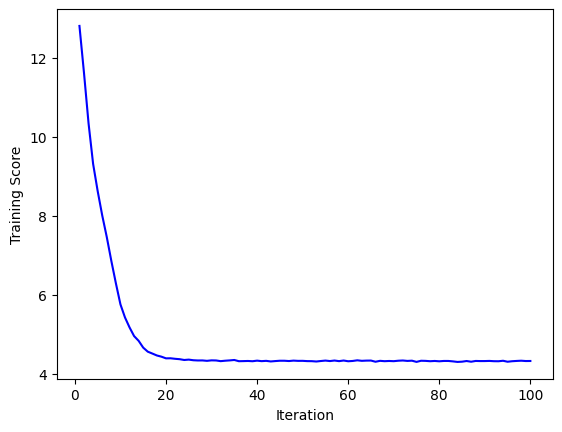

Dedicated Blue Agent 4


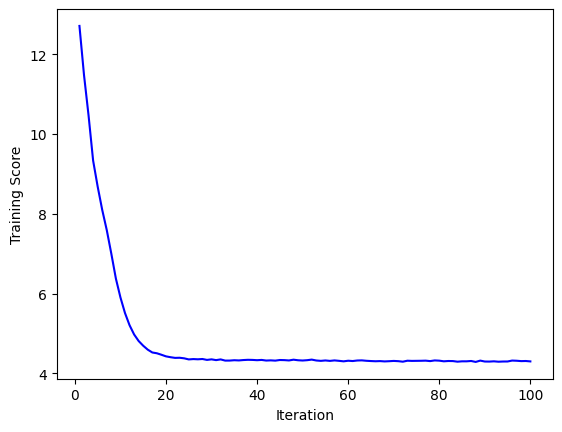

In [11]:
id_plot = [id for id in range(1,101)]
for g in range(1,5):
    print(f'Dedicated Blue Agent {g}')
    data_plot = pd.DataFrame({"Iteration":id_plot, "Training Score":blue_scores[g]})
    plt.figure()
    sns.lineplot(x = "Iteration", y = "Training Score", data=data_plot, color='blue')
    plt.show()

#### Sample Game Between Competitive Policies

In [12]:
ray.init(ignore_reinit_error=True, log_to_driver=False)

red = build_red_agent(workers=1, fresh=False)
blue = build_blue_agent(workers=1, fresh=False)

In [13]:
path_file = open(f"./policies/competitive_blue_policy", "r")
blue_restore_path = path_file.read()
path_file.close()
blue.restore(blue_restore_path)

path_file = open(f"./policies/competitive_red_policy", "r")
red_restore_path = path_file.read()
path_file.close()
red.restore(red_restore_path)

sample(red, blue, verbose=True, show_policy=True)

---- Turn 1 ----
Blue policy: 
['Monitor']: 12.85%
('Analyse', 'Op_Host0'): 8.97%
('Analyse', 'Op_Server0'): 9.98%
('Analyse', 'User1'): 10.74%
('Analyse', 'User2'): 5.55%
('Analyse', 'User3'): 6.38%
('Remove', 'Op_Host0'): 10.62%
('Remove', 'Op_Server0'): 7.24%
('Remove', 'User1'): 10.68%
('Remove', 'User2'): 8.49%
('Remove', 'User3'): 8.47%
('Restore', 'Op_Host0'): 0.00%
('Restore', 'Op_Server0'): 0.01%
('Restore', 'User1'): 0.00%
('Restore', 'User2'): 0.00%
('Restore', 'User3'): 0.00%
Blue selects ('Analyse', 'User1') with probability 10.74%

Red Policy: 
['Sleep']: 0.01%
['Impact']: 0.01%
('DiscoverSystems', 'Op'): 0.00%
('DiscoverSystems', 'User'): 99.90%
('DiscoverServices', 'Op_Host0'): 0.01%
('DiscoverServices', 'Op_Server0'): 0.01%
('DiscoverServices', 'User1'): 0.01%
('DiscoverServices', 'User2'): 0.00%
('DiscoverServices', 'User3'): 0.01%
('ExploitServices', 'Op_Host0'): 0.00%
('ExploitServices', 'Op_Server0'): 0.00%
('ExploitServices', 'User1'): 0.01%
('ExploitServices', 'U

3.8000000000000007

#### Sample Game between Competitive Blue and Dedicated Red

In [14]:
red = build_red_agent(dedicated=True, workers=1, fresh=False)
blue = build_blue_agent(workers=1, fresh=False)

In [15]:
path_file = open(f"./policies/competitive_blue_policy", "r")
blue_restore_path = path_file.read()
path_file.close()
blue.restore(blue_restore_path)

path_file = open(f"./policies/dedicated_red_policy", "r")
red_restore_path = path_file.read()
path_file.close()
red.restore(red_restore_path)

sample(red, blue, verbose=True, show_policy=True)

---- Turn 1 ----
Blue policy: 
['Monitor']: 12.85%
('Analyse', 'Op_Host0'): 8.97%
('Analyse', 'Op_Server0'): 9.98%
('Analyse', 'User1'): 10.74%
('Analyse', 'User2'): 5.55%
('Analyse', 'User3'): 6.38%
('Remove', 'Op_Host0'): 10.62%
('Remove', 'Op_Server0'): 7.24%
('Remove', 'User1'): 10.68%
('Remove', 'User2'): 8.49%
('Remove', 'User3'): 8.47%
('Restore', 'Op_Host0'): 0.00%
('Restore', 'Op_Server0'): 0.01%
('Restore', 'User1'): 0.00%
('Restore', 'User2'): 0.00%
('Restore', 'User3'): 0.00%
Blue selects ('Remove', 'Op_Server0') with probability 7.24%

Red Policy: 
['Sleep']: 0.00%
['Impact']: 0.00%
('DiscoverSystems', 'Op'): 0.00%
('DiscoverSystems', 'User'): 99.98%
('DiscoverServices', 'Op_Host0'): 0.00%
('DiscoverServices', 'Op_Server0'): 0.00%
('DiscoverServices', 'User1'): 0.00%
('DiscoverServices', 'User2'): 0.00%
('DiscoverServices', 'User3'): 0.00%
('ExploitServices', 'Op_Host0'): 0.00%
('ExploitServices', 'Op_Server0'): 0.00%
('ExploitServices', 'User1'): 0.00%
('ExploitServices',

7.0

#### Sample Game between Dedicated Blue and Competitive Red

In [16]:
red = build_red_agent(workers=1, fresh=False)
blue = build_blue_agent(dedicated=True, workers=1, fresh=False)

In [17]:
path_file = open(f"./policies/dedicated_blue_policy", "r")
blue_restore_path = path_file.read()
path_file.close()
blue.restore(blue_restore_path)

path_file = open(f"./policies/competitive_red_policy", "r")
red_restore_path = path_file.read()
path_file.close()
red.restore(red_restore_path)

sample(red, blue, verbose=True, show_policy=True)

---- Turn 1 ----
Blue policy: 
['Monitor']: 4.31%
('Analyse', 'Op_Host0'): 17.01%
('Analyse', 'Op_Server0'): 4.51%
('Analyse', 'User1'): 19.18%
('Analyse', 'User2'): 9.75%
('Analyse', 'User3'): 6.45%
('Remove', 'Op_Host0'): 7.22%
('Remove', 'Op_Server0'): 11.70%
('Remove', 'User1'): 6.93%
('Remove', 'User2'): 2.00%
('Remove', 'User3'): 10.95%
('Restore', 'Op_Host0'): 0.00%
('Restore', 'Op_Server0'): 0.00%
('Restore', 'User1'): 0.00%
('Restore', 'User2'): 0.00%
('Restore', 'User3'): 0.00%
Blue selects ('Analyse', 'Op_Server0') with probability 4.51%

Red Policy: 
['Sleep']: 0.01%
['Impact']: 0.01%
('DiscoverSystems', 'Op'): 0.00%
('DiscoverSystems', 'User'): 99.90%
('DiscoverServices', 'Op_Host0'): 0.01%
('DiscoverServices', 'Op_Server0'): 0.01%
('DiscoverServices', 'User1'): 0.01%
('DiscoverServices', 'User2'): 0.00%
('DiscoverServices', 'User3'): 0.01%
('ExploitServices', 'Op_Host0'): 0.00%
('ExploitServices', 'Op_Server0'): 0.00%
('ExploitServices', 'User1'): 0.01%
('ExploitServices'

3.8000000000000007